In [37]:
import numpy as np
from pathlib import Path
import struct#用于数据类型的转换 bytes to str
import matplotlib.pyplot as plt

In [36]:
def Read_img_File(filepath):
    with open(filepath,'rb') as f:
        struct.unpack('>4i',f.read(16))#4i代表4位整型，int：占4字节，4*8=32bit
        data=np.fromfile(f,dtype=np.uint8)
        return data.reshape(-1,28*28)
    
def Read_label_File(filepath):
    with open(filepath,'rb') as f:
        struct.unpack('>2i',f.read(8))
        data=np.fromfile(f,dtype=np.uint8)
        return data
def loadDataSets():
    train_img_path='handwrite/train-images.idx3-ubyte'
    train_label_path='handwrite/train-labels.idx1-ubyte'
    test_img_path='handwrite/t10k-images.idx3-ubyte'
    test_label_path='handwrite/t10k-labels.idx1-ubyte'
    train_img=Read_img_File(train_img_path)
    train_label=Read_label_File(train_label_path)
    test_img=Read_img_File(test_img_path)
    test_label=Read_label_File(test_label_path)
    return train_img,train_label,test_img,test_label
train_img,train_label,test_img,test_label=loadDataSets()


label: 5


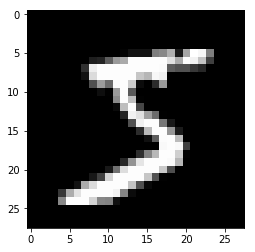

In [43]:
def show_img(img):
    plt.imshow(img.reshape(28,28),cmap='gray')
show_img(train_img[0])
print('label:',train_label[0])

In [44]:
print(train_img.shape,train_label.shape)

(60000, 784) (60000,)


In [115]:
#确定各层的激活项的个数
#输入层：784个，隐藏层数1：784个，输出层1：10个
layer_activity_num=[28*28,28*28,10]

#激活函数
def sigmoid(z):
    return 1/(1+np.exp(-z))
#
def theta_init():
    theta=[]
    for i in range(len(layer_activity_num)-1):
        m=layer_activity_num[0]+layer_activity_num[-1]
        theta_temp=np.random.uniform(-np.sqrt(6/m),np.sqrt(6/m),size=(layer_activity_num[i]+1,layer_activity_num[i+1]))
        #one_temp=np.ones((1,layer_activity_num[i+1]))
        theta.append(theta_temp)
    return theta
theta=theta_init()
print(theta)
print(theta[0].shape)
print(theta[1].T.shape)


[array([[ 0.02324871, -0.01645236, -0.04711592, ..., -0.02343539,
        -0.00321856,  0.01852405],
       [-0.00996692, -0.03172074,  0.01507299, ...,  0.02484151,
        -0.03432506, -0.01169094],
       [-0.06921828, -0.0718516 , -0.01834473, ...,  0.07694013,
         0.06350388,  0.00436009],
       ...,
       [ 0.02198345, -0.0714965 , -0.08295002, ...,  0.01998184,
         0.01115084,  0.07497953],
       [ 0.04271905, -0.01354546,  0.08417099, ...,  0.08314746,
        -0.02675249,  0.04156705],
       [ 0.01245913,  0.06034856, -0.04952406, ..., -0.03614595,
        -0.02199128, -0.03793315]]), array([[ 0.05665412,  0.02745212,  0.04451176, ..., -0.08537065,
         0.07288527, -0.05460734],
       [ 0.06696652,  0.07153458, -0.0003367 , ..., -0.06118479,
         0.01772678, -0.03394919],
       [ 0.00382465,  0.05949441,  0.00390115, ...,  0.04157018,
         0.05316124, -0.0386559 ],
       ...,
       [ 0.01979744, -0.04074409,  0.07470328, ...,  0.06399092,
        

In [127]:
X=train_img[:10000,:].T
print(X.shape)
X=np.vstack([np.ones((1,X.shape[1])),X])

Z=theta[0].T.dot(X)
sigmoid(Z).shape
#sigmoid(theta[0].T.dot(X))


(784, 10000)


(784, 10000)

In [98]:
X=train_img[:10000,:]
print(X.shape)
np.ones((1,X.shape[1])).shape

(10000, 784)


(1, 784)

In [182]:
#正向传播
def ForwardPropagation(X,theta):
    a=X.T #某层的激活项
    activity=[]#记录所有层的激活项
    for i in range(len(layer_activity_num)-1):
        a=np.vstack([np.ones((1,a.shape[1])),a])
        Z=theta[i].T.dot(a)
        a=sigmoid(Z)
        activity.append(a)
    return activity
#输入值
X=train_img[:10000,:]
#标签对应的向量
Y_label=train_label[:10000]
Y_exa=np.identity(10)
Y=Y_exa[Y_label[0]].reshape(-1,1)
for i in range(1,Y_label.shape[0]):
    Y=np.hstack([Y,Y_exa[Y_label[i]].reshape(-1,1)])
#
activity=ForwardPropagation(X,theta)
Y_predict=activity[-1]
# print(activity)
print(X.shape,Y_predict.shape,Y_label.shape)

(10000, 784) (10, 10000) (10000,)


In [202]:
((np.delete(theta[0],0,axis=0)**2)*1)/(2*1000)

array([[4.96697748e-08, 5.03102653e-07, 1.13597574e-07, ...,
        3.08550218e-07, 5.89104983e-07, 6.83390451e-08],
       [2.39558491e-06, 2.58132619e-06, 1.68264558e-07, ...,
        2.95989197e-06, 2.01637135e-06, 9.50520746e-09],
       [2.04647860e-06, 4.24385160e-07, 6.21496195e-09, ...,
        2.68361285e-06, 4.62604297e-07, 2.08322723e-06],
       ...,
       [2.41636002e-07, 2.55587500e-06, 3.44035282e-06, ...,
        1.99636954e-07, 6.21706595e-08, 2.81096494e-06],
       [9.12458793e-07, 9.17397760e-08, 3.54237765e-06, ...,
        3.45674992e-06, 3.57847982e-07, 8.63909920e-07],
       [7.76150156e-08, 1.82097447e-06, 1.22631606e-06, ...,
        6.53264779e-07, 2.41808192e-07, 7.19461968e-07]])

In [208]:
print(theta[0].shape,np.delete(theta[1],0,axis=0).shape)


(785, 784) (784, 10)


AttributeError: 'list' object has no attribute 'shape'

In [218]:
print(np.log(Y_predict)[:,0],Y[:,0])
print(np.log(Y_predict)[:,0]*Y[:,0])



[-1.16344154 -1.01943029 -0.40660572 -0.25186286 -0.52493807 -1.17195972
 -0.11695655 -0.77646763 -0.46970049 -0.36568822] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[-0.         -0.         -0.         -0.         -0.         -1.17195972
 -0.         -0.         -0.         -0.        ]


(10, 10000)

In [219]:
#计算代价
def cost_function(activity,theta,Y_predict,Lamaba):
    m=X.shape[0]
    part1=-(Y*np.log(Y_predict)+(1-Y)*np.log(1-Y_predict)).sum()/m
    part2=0
    for i in range(len(theta)):
        part2+=((np.delete(theta[i],0,axis=0)**2).sum()*Lamaba)/(2*m)
    J=part1+part2
    return J

lamada=1
cost_function(activity,theta,Y_predict,lamada)

8.557313741570646

In [ ]:
#反向传播
def Backpropagation():
    

In [217]:
a = np.arange(4).reshape(1,-1)
b = np.repeat(1, 10).reshape(2,-1)
print(a,a.sum())
# print(b)
c=np.vstack([a,b])

s=np.delete(c,0,axis=0)
print(c)

[[0 1 2 3]] 6


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [152]:
np.array([1])

array([1])